In [33]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_normalised_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [34]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 900]


times = np.linspace(20, 97, 78)

df = pd.read_csv('s11_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)
centred_moment_5 = moment(org_values, moment=5, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((78,5))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)
out_array[:,4] = np.divide(centred_moment_5,st_dev*st_dev*st_dev*st_dev*st_dev)

print(st_dev)

print(np.mean(org_values, axis=1))
print(centred_moment_3)

# print(centred_moments.shape)


[10.06376669  9.63391276  9.39582886  9.22513415  8.81750957  8.32179518
  7.83460912  7.85188512  7.54667311  7.48145039  7.11961375  6.99227252
  6.58293248  6.39531078  6.04660235  5.69082375  5.48378291  5.217612
  4.99342317  4.73428717  4.51302559  4.35228676  4.11629688  3.88418267
  3.55573832  3.50006786  3.41128641  3.25844672  3.04274136  2.94558568
  2.84015405  2.73372914  2.58696734  2.42038737  2.24910538  2.26218921
  2.120283    2.01078965  2.06121323  1.98128115  1.94598947  1.87480666
  1.81104942  1.72455791  1.69099823  1.61511609  1.5833193   1.43808901
  1.50727403  1.43788038  1.38573987  1.36747943  1.26581002  1.2495099
  1.2437343   1.25383412  1.22371361  1.18003178  1.12343224  1.17349904
  1.11860404  1.10021589  1.06719258  0.96709617  0.99673216  1.00965341
  1.00919522  0.93829633  0.97626841  0.90657322  0.86890736  0.81357237
  0.75714926  0.77142725  0.79693162  0.72143953  0.77942286  0.6609652 ]
[2.34  2.265 2.28  2.37  2.345 2.235 2.17  2.23  2.23

Add noise to the data (using random sampling from normal distribution)

In [35]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 5
noise_value = 25
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
noise_arr[0] = 1
noise_arr[1] = 1
noise_arr[2] = 1
noise_arr[3] = 1
noise_arr[4] = 1


Set-up pints problem and log likelihoods

In [36]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 2
New dimension: 7


Create uniform log prior

In [37]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 1
prior_arr_upper[1] = 4000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 100
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_324/1430441265.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [38]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     513     0:01.5
2     1011    0:03.1
3     1494    0:04.5
20    8637    0:26.6
40    15267   0:48.6
60    20910   1:07.9
80    26493   1:26.8
100   32478   1:46.8
120   38103   2:06.2
140   44178   2:26.8
160   49926   2:46.4
180   55731   3:06.4
200   61746   3:28.0
220   67725   3:49.3
240   73752   4:11.2
260   79596   4:31.9
280   85392   4:52.5
300   91320   5:13.6
320   97164   5:34.6
340   103047   5:56.4
360   109044   6:18.7
380   115047   6:40.9
400   120999   7:02.3
420   126645   7:22.6
440   132546   7:43.7
460   138315   8:04.1
480   143961   8:24.4
500   149928   8:45.9
520   155745   9:07.0
540   161412   9:27.5
560   167328   9:48.9
580   173016  10:09.3
600   179079  10:31.5
620   185055  10:53.2
640   190932  11:14.7
660   196803  11:35.6
680   202821  11:57.4
700   208551  12:18.2
720   214314  12:38.7
740   220170  12:59.7
760   226206  13

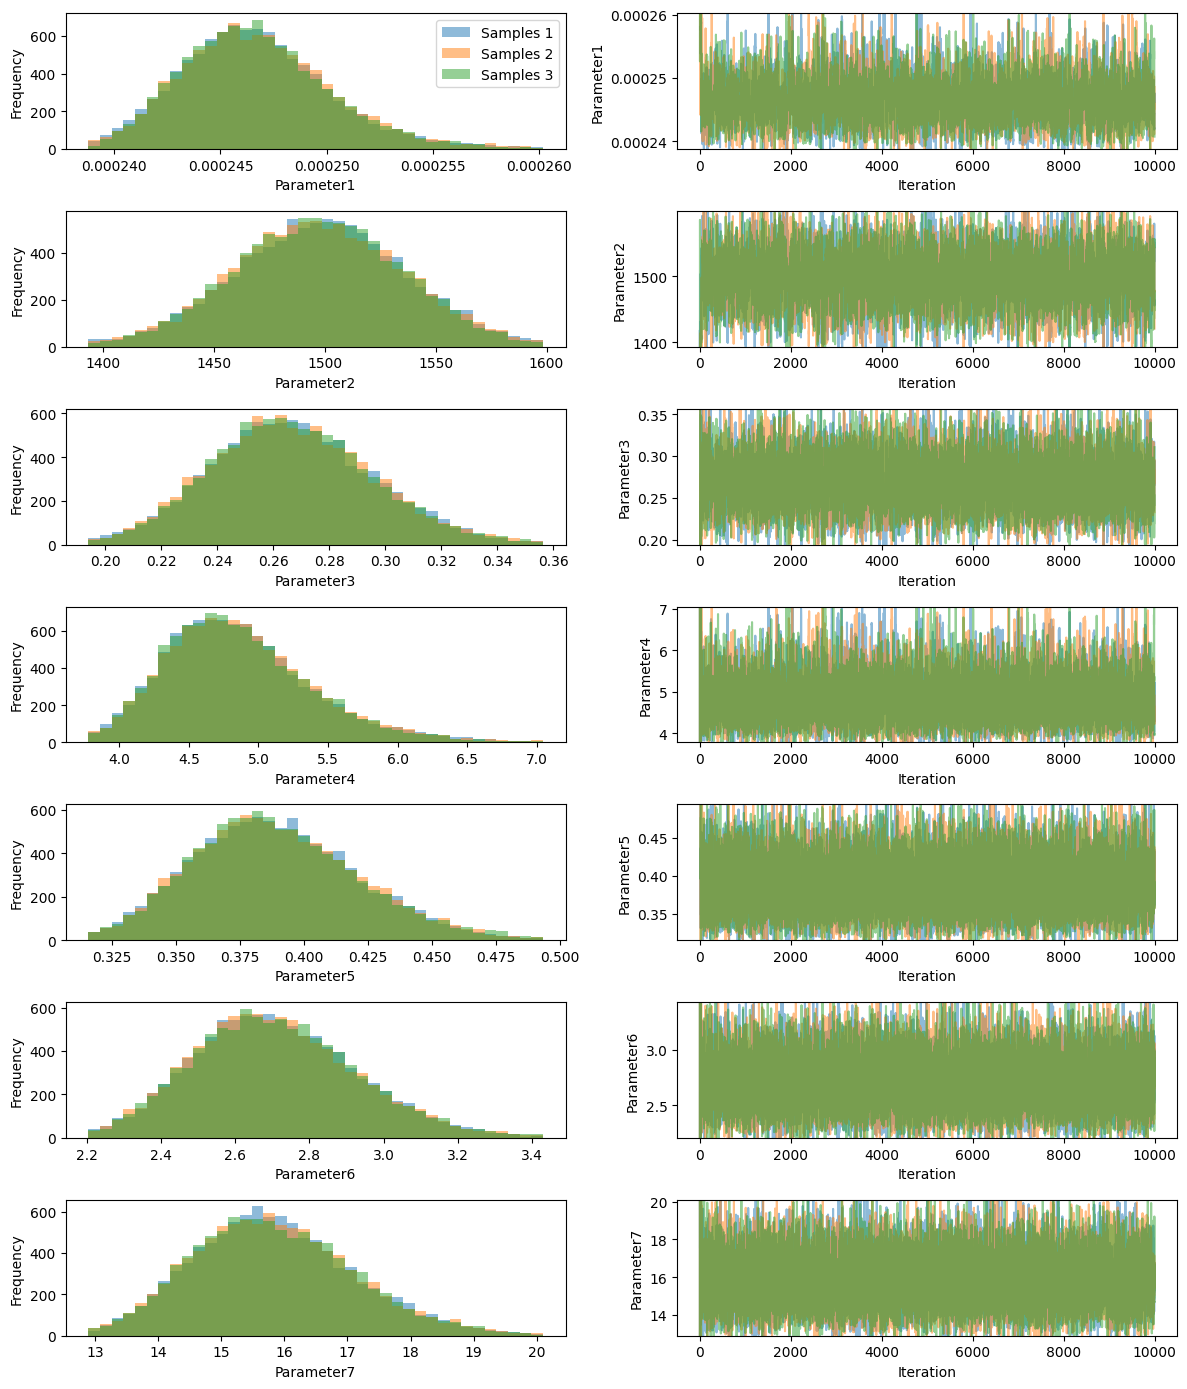

In [53]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [40]:

# ITERS = 100
AllChains = chains[0,100:1000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(900, 7)
[2.42385724e-04 1.53256794e+03 2.63546402e-01 4.87711880e+00
 4.48158103e-01 2.53570383e+00 1.41234754e+01]
[[2.42385724e-04 1.53256794e+03 2.63546402e-01 ... 4.48158103e-01
  2.53570383e+00 1.41234754e+01]
 [2.45674318e-04 1.53200972e+03 2.62963535e-01 ... 3.28380090e-01
  2.68451553e+00 1.31789569e+01]
 [2.46513751e-04 1.49917048e+03 2.68660027e-01 ... 4.23377631e-01
  2.81344898e+00 1.60921298e+01]
 ...
 [2.52864866e-04 1.39679870e+03 2.47999674e-01 ... 4.36111343e-01
  2.65354198e+00 1.47184211e+01]
 [2.52795355e-04 1.49904771e+03 2.14968067e-01 ... 3.63562591e-01
  2.52520700e+00 1.38779572e+01]
 [2.52278121e-04 1.43765434e+03 2.30546855e-01 ... 4.37819837e-01
  2.89020485e+00 1.70057593e+01]]


In [41]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:1000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


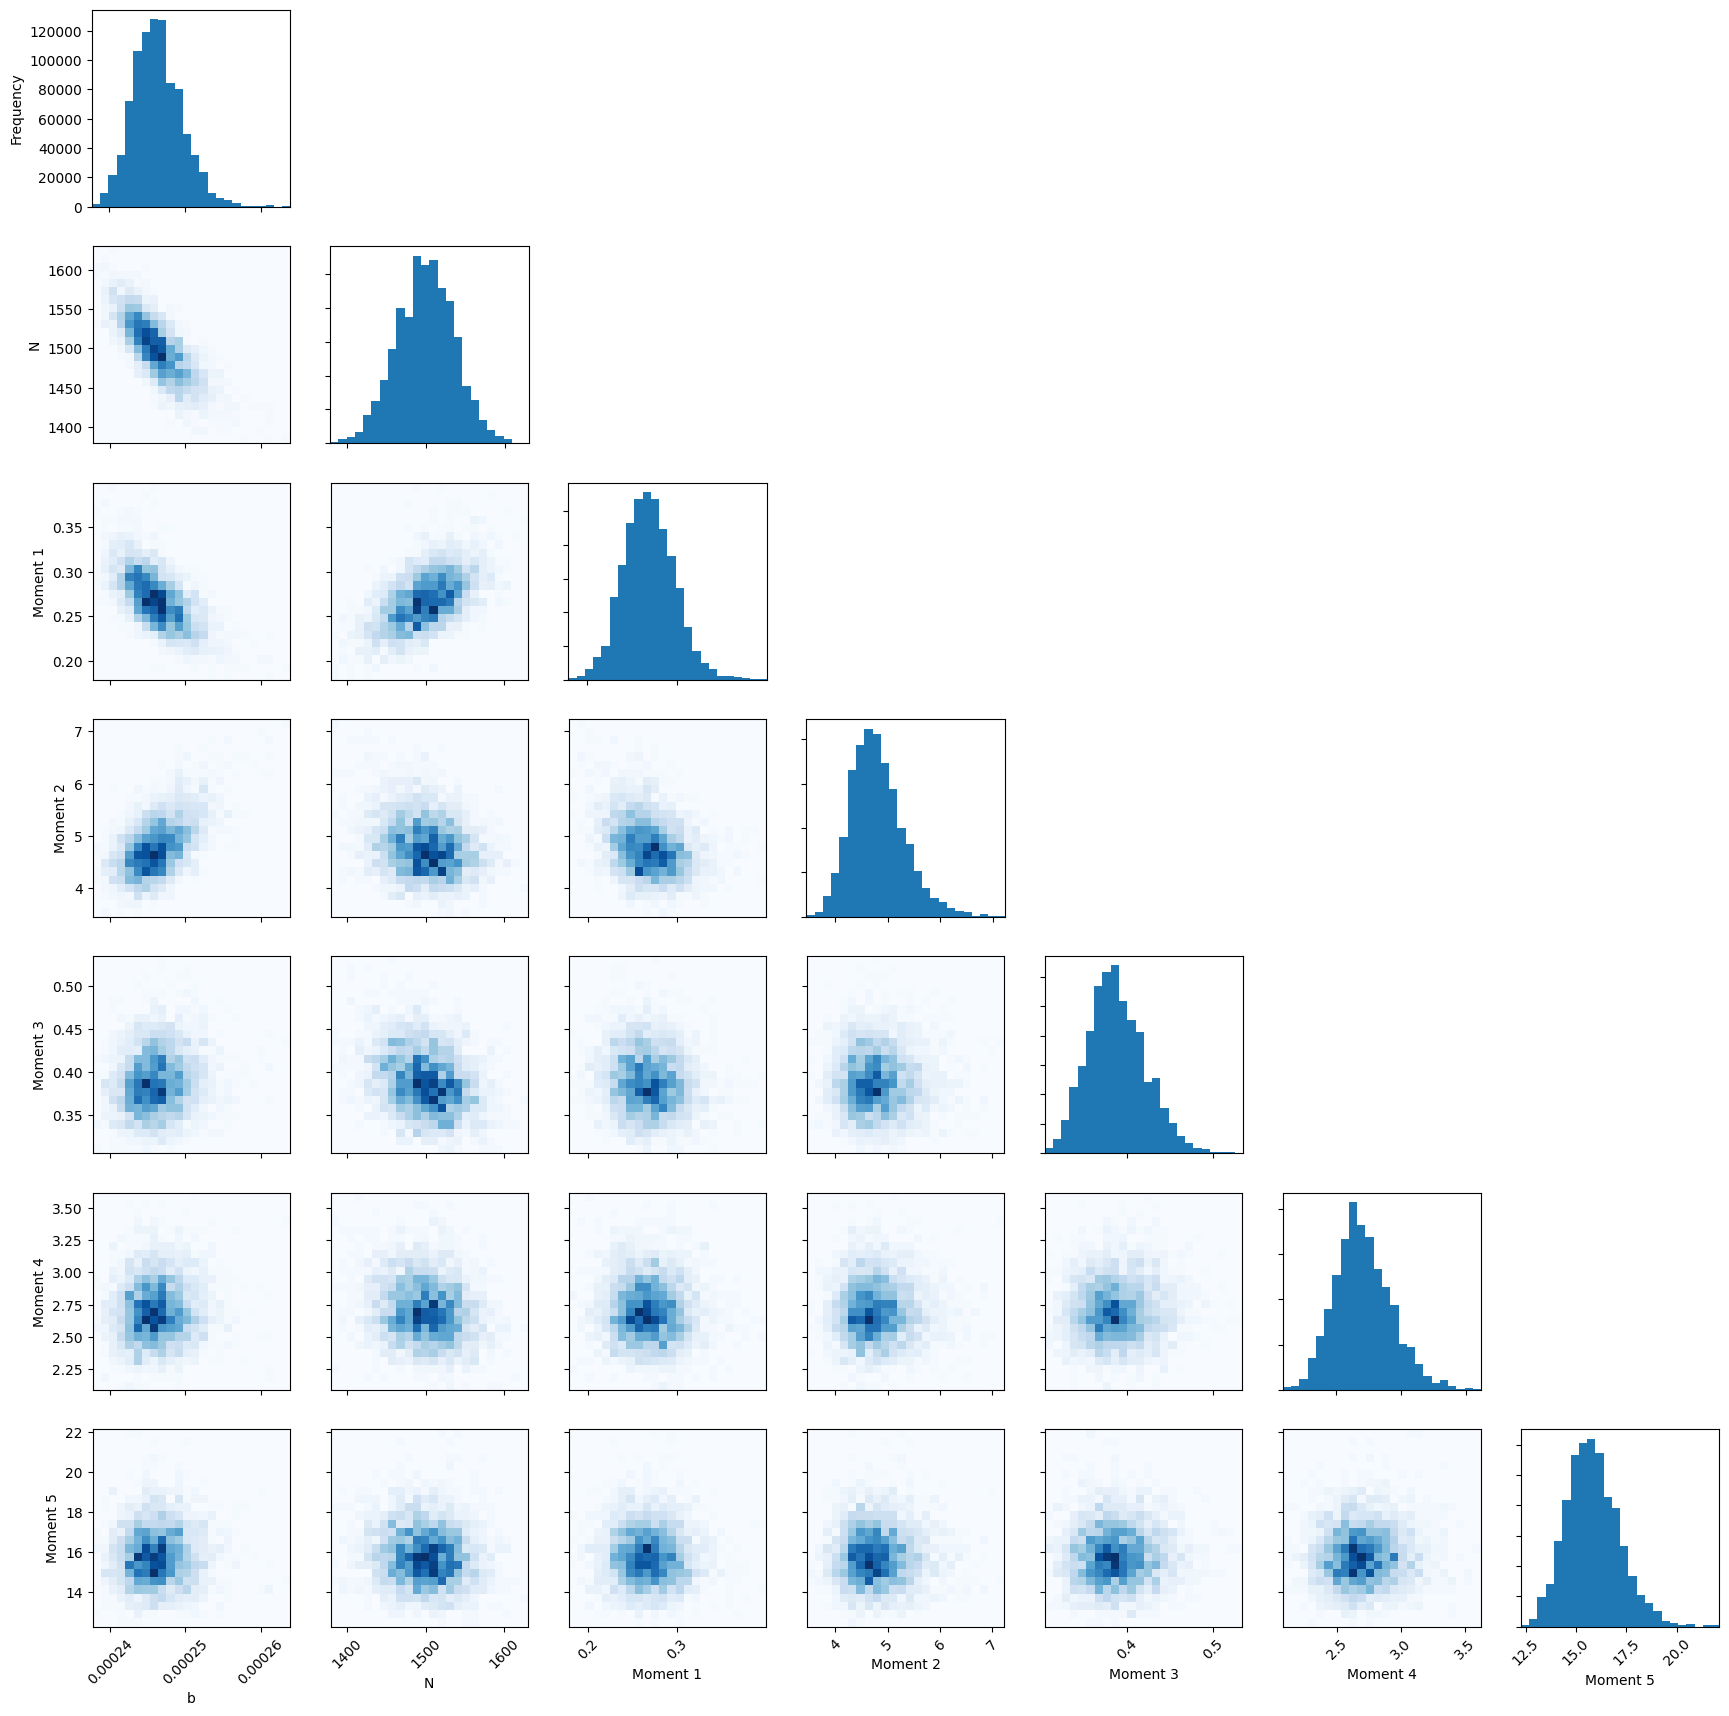

In [54]:


parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"])
plt.show()

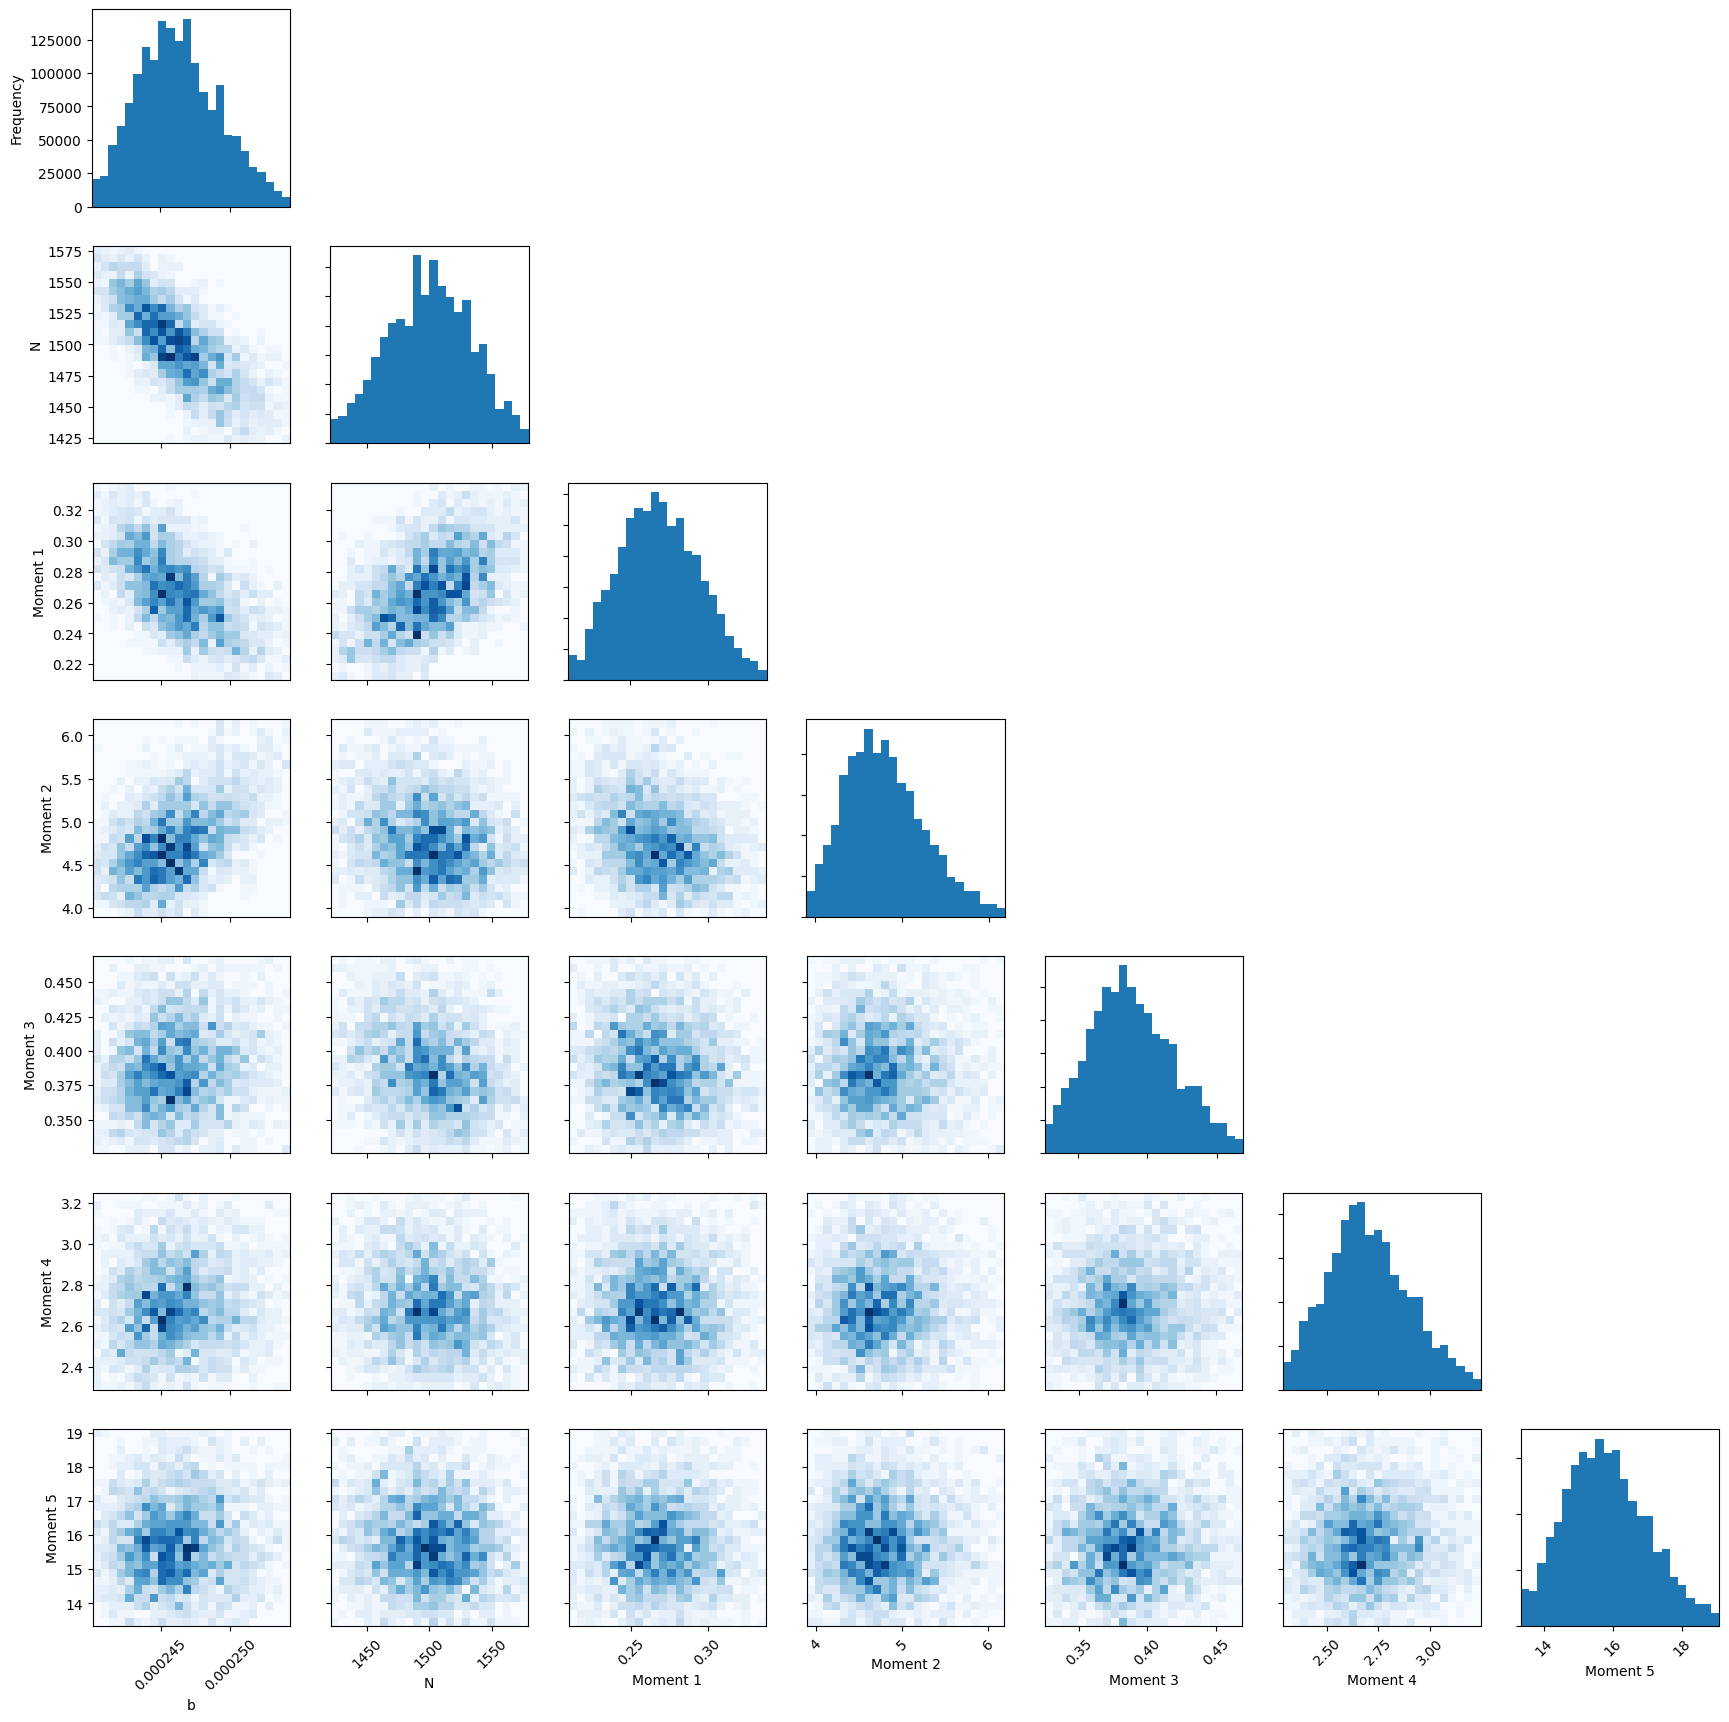

In [43]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"],
                    n_percentiles=97)
                    
plt.show()

[2.42385724e-04 1.53256794e+03 2.63546402e-01 4.87711880e+00
 4.48158103e-01 2.53570383e+00 1.41234754e+01]


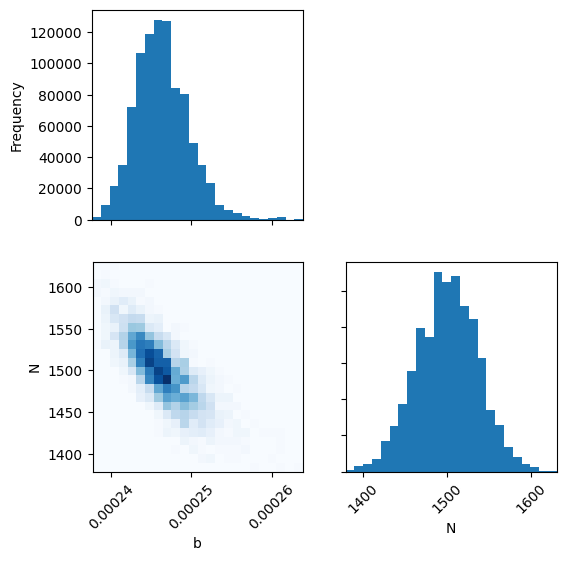

In [55]:
parameter_names = ["b","N"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1]], heatmap=True, 
                    parameter_names=["b","N"])
plt.savefig("Pints_pairwise.png", dpi =300)
plt.show()


In [45]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean     std.    2.5%     25%      50%      75%      97.5%    rhat    ess      ess per sec.
--------  -------  ------  -------  -------  -------  -------  -------  ------  -------  --------------
b         0.00     0.00    0.00     0.00     0.00     0.00     0.00     1.00    1342.74  0.14
N         1497.56  38.82   1421.93  1471.13  1496.90  1523.39  1574.75  1.00    1574.94  0.16
Moment 1  0.27     0.03    0.21     0.25     0.26     0.29     0.33     1.00    1948.50  0.20
Moment 2  4.87     0.54    3.99     4.49     4.80     5.16     6.11     1.00    2359.14  0.24
Moment 3  0.39     0.03    0.33     0.37     0.39     0.41     0.46     1.00    4452.64  0.45
Moment 4  2.71     0.22    2.31     2.55     2.70     2.85     3.19     1.00    4674.98  0.47
Moment 5  15.83    1.31    13.53    14.92    15.75    16.66    18.65    1.00    4696.50  0.47


In [46]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [47]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.     2.5%      25%       50%       75%       97.5%     rhat    ess       ess per sec.
--------  --------  -------  --------  --------  --------  --------  --------  ------  --------  --------------
b         0.000247  3.6e-06  0.00024   0.000244  0.000246  0.000249  0.000255  1       1.34e+03  0.136
N         1.5e+03   38.8     1.42e+03  1.47e+03  1.5e+03   1.52e+03  1.57e+03  1       1.57e+03  0.159
Moment 1  0.267     0.0296   0.213     0.246     0.265     0.285     0.33      1       1.95e+03  0.197
Moment 2  4.87      0.537    3.99      4.49      4.8       5.16      6.11      1       2.36e+03  0.238
Moment 3  0.389     0.0331   0.33      0.366     0.387     0.41      0.46      1       4.45e+03  0.45
Moment 4  2.71      0.224    2.31      2.55      2.7       2.85      3.19      1       4.67e+03  0.472
Moment 5  15.8      1.31     13.5      14.9      15.7      16.7      18.6      1       4.7e+03   0.474


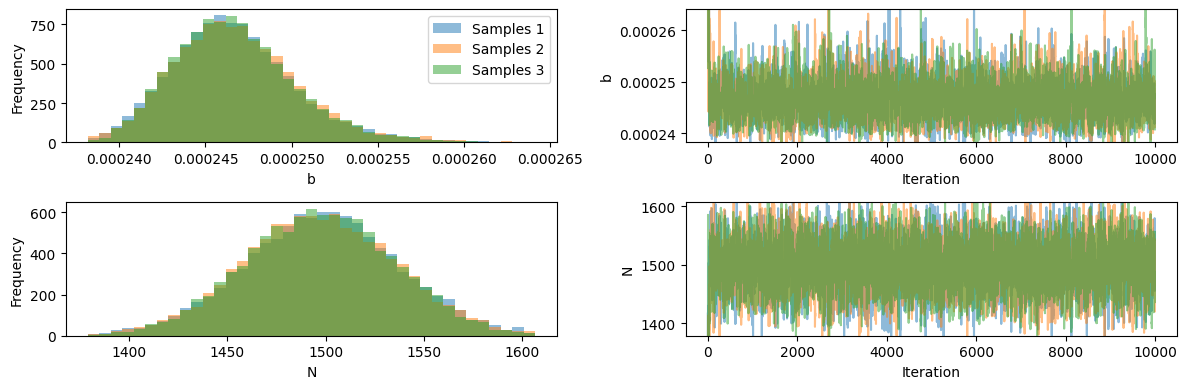

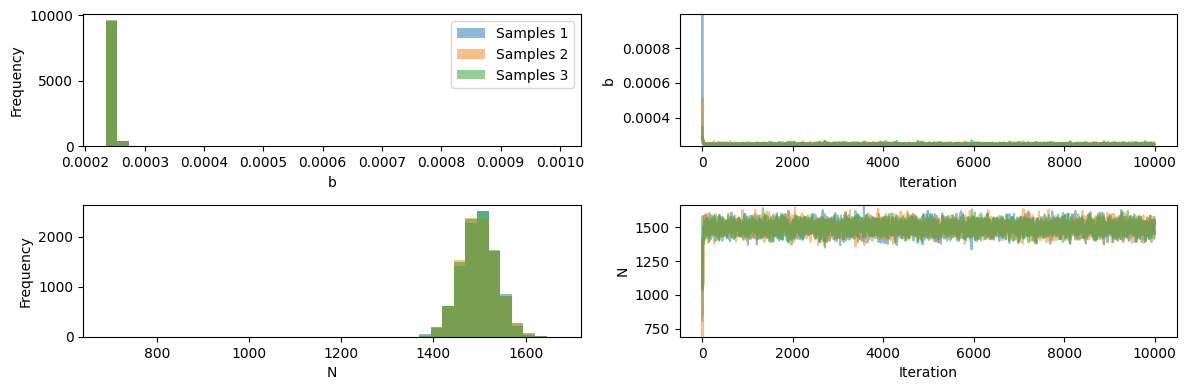

In [48]:
pints.plot.trace(chains[:,:,[0,1]], n_percentiles=99.5, parameter_names=["b","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1]], parameter_names=["b","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()